In [1]:
import os
import torch
import warnings
import numpy as np
import pandas as pd

from torch import nn
from tqdm.notebook import tqdm
from transformers import pipeline, get_scheduler
from torch.utils.data import Dataset, DataLoader

from solution import Solution
from learning_loop import learning_loop
from contractDataset import ContractsDataset
from model import gptKILLER, create_model_and_optimizer
from zoo_params import zoo_params, create_name

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
d_train = pd.read_json("nlp_test_task_2023/dataset/train.json")
d_train['unique_id'] = np.arange(len(d_train))

In [3]:
np.random.seed(777)
id_train = []
id_test = []
labels = ["обеспечение исполнения контракта", "обеспечение гарантийных обязательств"]
p = 0.7
for label in labels:
    ids = d_train[d_train.label == label].unique_id.to_numpy()
    mask = np.random.choice([0, 1], size=len(ids), p=[p, 1 - p])
    id_test.extend(ids[mask == 1])
    id_train.extend(ids[mask == 0])

In [4]:
qa_pipeline = pipeline(
    "question-answering",
    model="Den4ikAI/rubert-tiny-squad",
    tokenizer="Den4ikAI/rubert-tiny-squad"
)
tokenizer  = qa_pipeline.tokenizer

In [5]:
def get_pipeline():
    return pipeline(
        "question-answering",
        model="Den4ikAI/rubert-tiny-squad",
        tokenizer="Den4ikAI/rubert-tiny-squad"
    )

In [6]:
# 371
# 1121
# 1131
# 1473

In [7]:
d_train.iloc[1121].extracted_part["text"][0] +=  "лей 00 копеек."
d_train.iloc[371].extracted_part["text"][0] +=  "ублей ____ копеек."
d_train.iloc[1131].extracted_part["text"][0] +=  "лей 50 копеек"
d_train.iloc[1473].extracted_part["text"][0] =  d_train.iloc[1473].extracted_part["text"][0][:-12]

In [8]:
ds_train = ContractsDataset(d_train.iloc[id_train], tokenizer)
ds_val = ContractsDataset(d_train.iloc[id_test], tokenizer)

In [9]:
def collate_fn(batch):
    question_batch = torch.stack([elem[0] for elem in batch])
    types_batch = torch.stack([elem[1] for elem in batch])
    attention_mask_batch = torch.stack([elem[2] for elem in batch])
    start_batch = torch.Tensor([elem[3] for elem in batch]).long()
    end_batch = torch.Tensor([elem[4] for elem in batch]).long()
    return question_batch, types_batch, attention_mask_batch, start_batch, end_batch

In [10]:
batch_size = 16

dataloader_train = DataLoader(
    dataset=ds_train,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

dataloader_val = DataLoader(
    dataset=ds_val,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=False,
)

In [11]:
def learn_model_with(params, model_name, save_index):
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    params["model"]["pipeline"] = get_pipeline()
    model, optimizer = create_model_and_optimizer(
        model_class = gptKILLER,
        model_params = params["model"],
        lr = params["start_lr"],
        device = device,
    )
    
    if params["scheduler"] == "ReduceLROnPlateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=4, threshold=0.001, verbose=True)
    else:
        scheduler = get_scheduler("cosine_with_restarts", optimizer, 10, 60)
    
    criterion = nn.NLLLoss()

    model, optimizer, losses, metrics = learning_loop(
        model = model,
        optimizer = optimizer,
        train_loader = dataloader_train,
        val_loader = dataloader_val,
        criterion = criterion,
        device = device,
        scheduler = scheduler,
        epochs = 100,
        min_lr = 1e-7,
        val_every = 1,
        draw_every = 1,
        separate_show = False,
        metric_names = {
            "accuracy": {"top": [1, 3], "plot_id": 1},
        },
        chkp_folder = "./chkp",
        model_name = model_name
    )
    torch.save(
        {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'losses': losses
        },
        os.path.join("./chkp", model_name, f'{model_name}.pt'),
    )
    
    sol = Solution(
        metrics, 
        params["model"]["count_of_blocks"], 
        params["start_lr"], 
        params["scheduler"], 
        params["model"]["hid_size"], 
        params["model"]["frozen_bert"]
    )
    
    sol.save_to_file("sol/", f"{save_index}.pkl")
    torch.cuda.empty_cache()

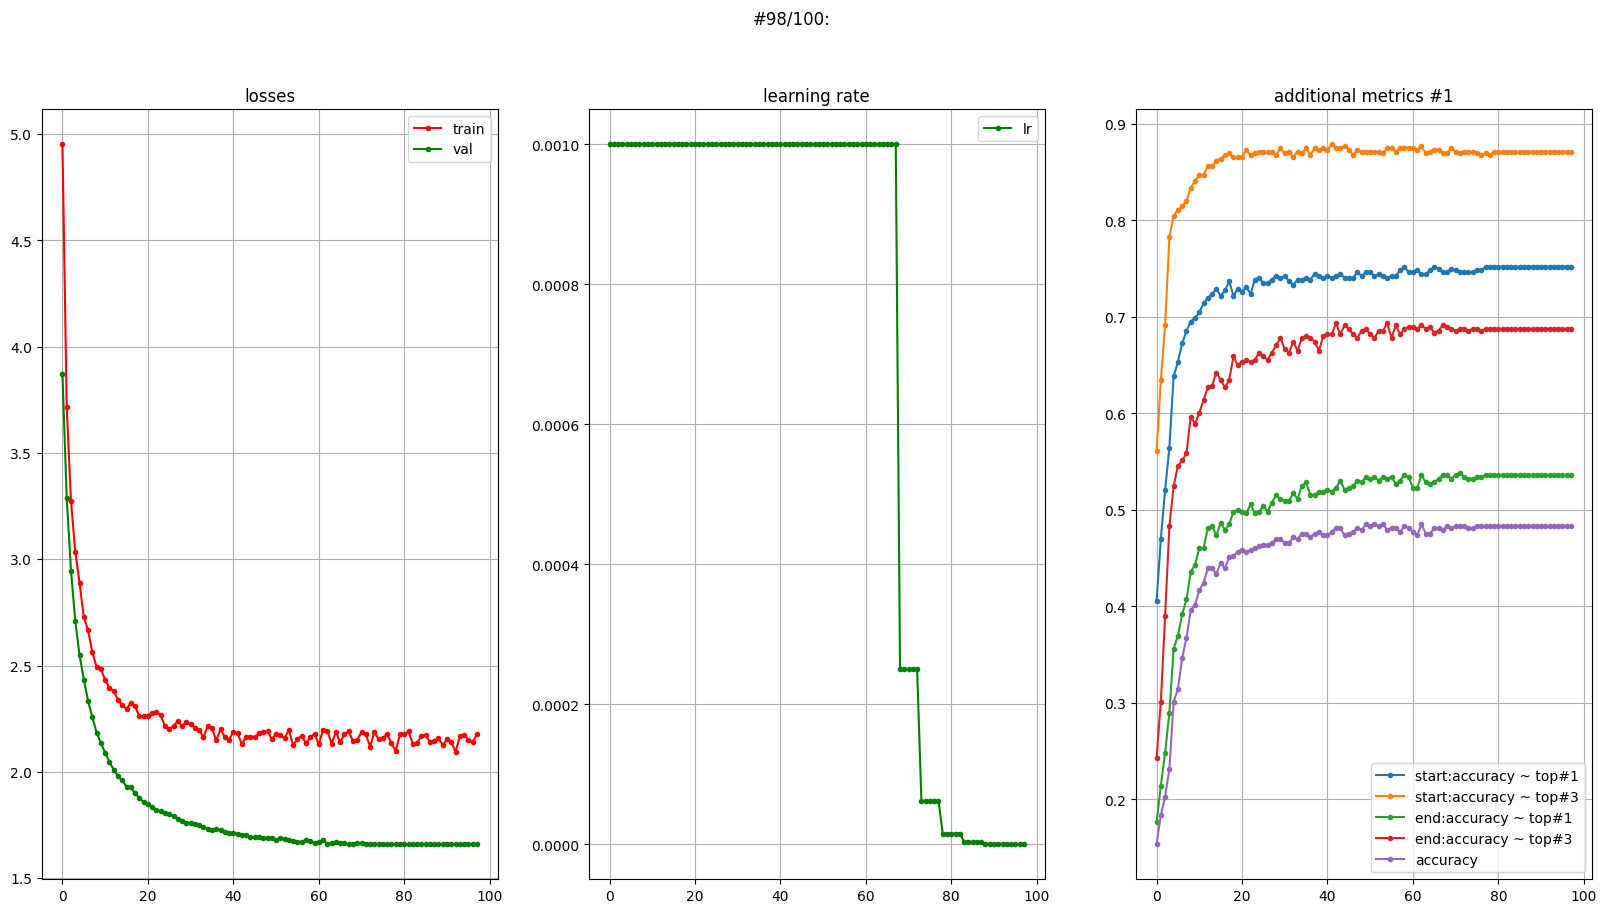

Learning process ended with early stop after epoch 98


In [15]:
params_index = 0
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)

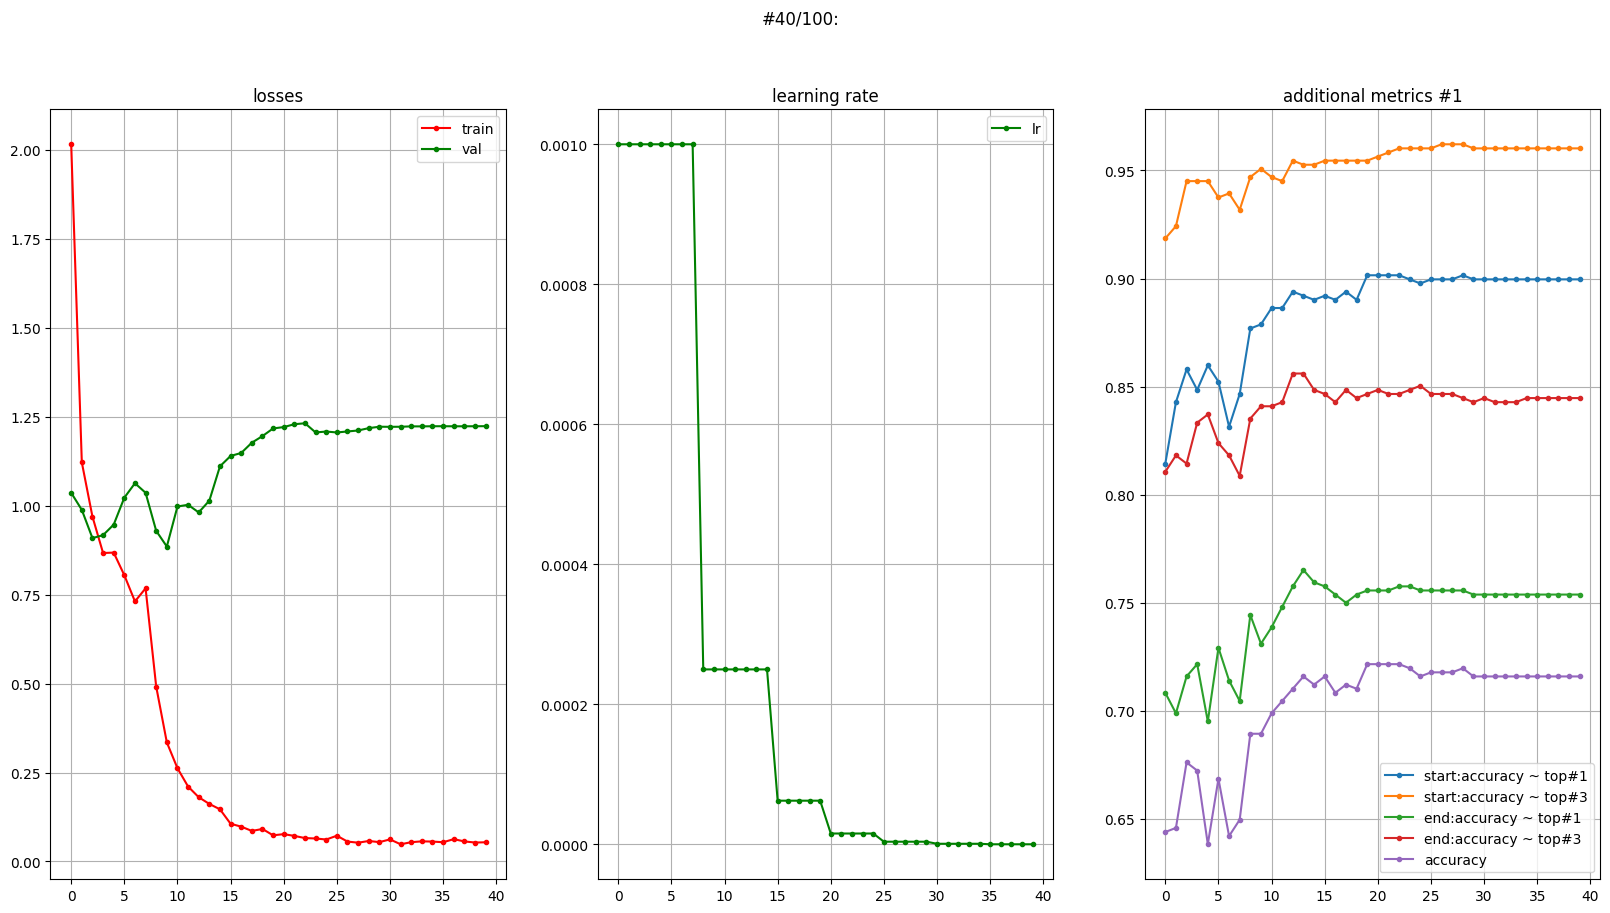

Learning process ended with early stop after epoch 40


In [16]:
params_index = 1
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)

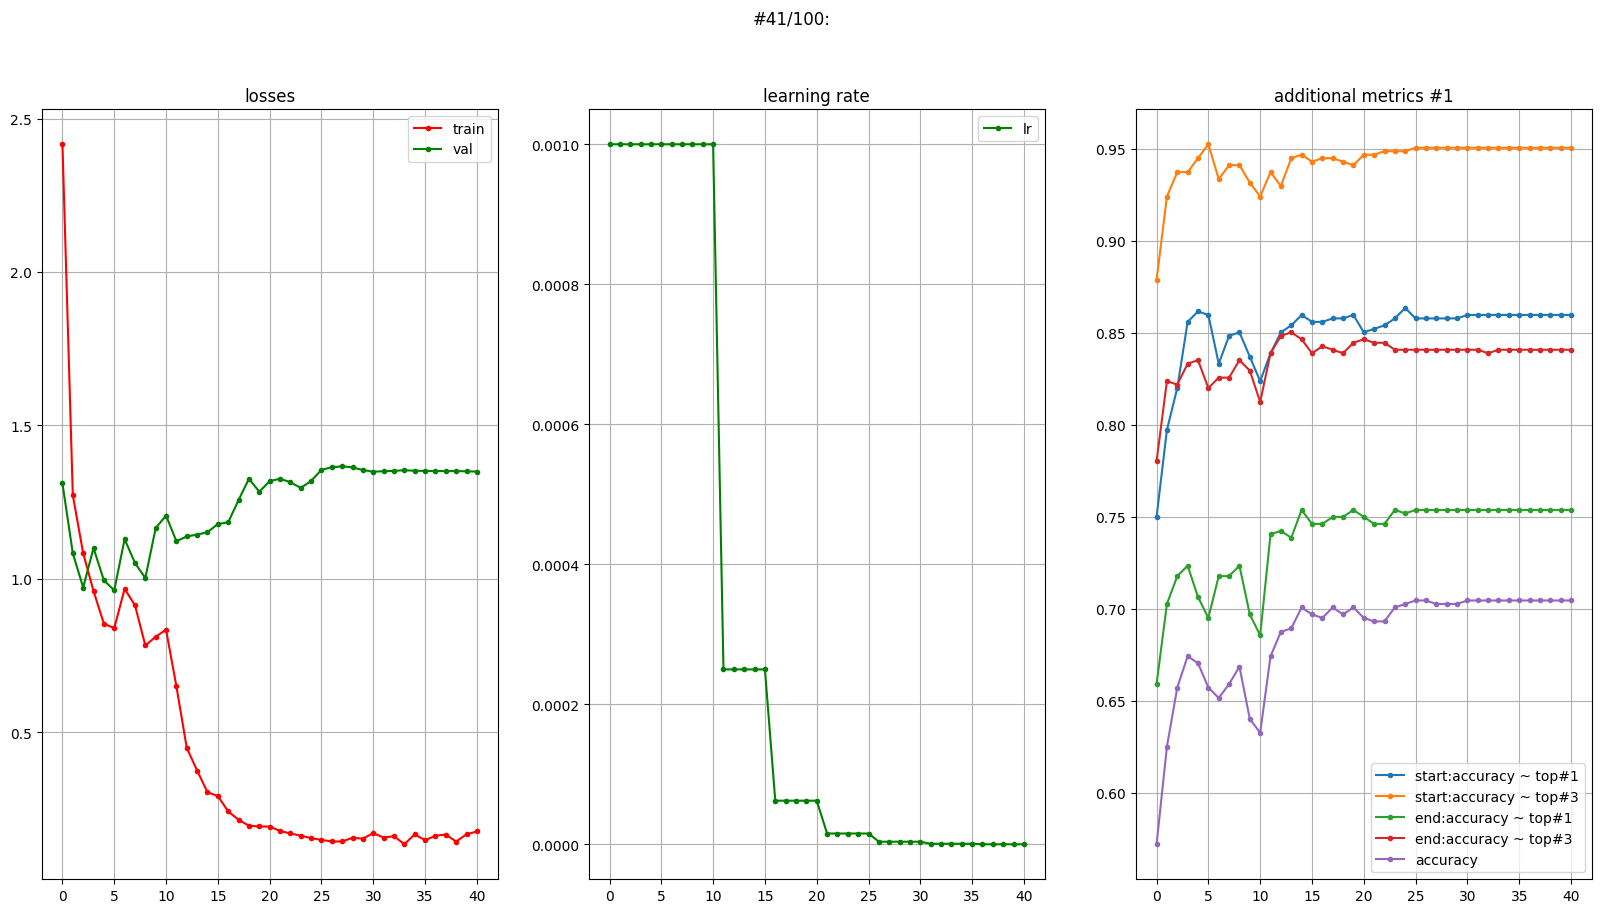

Learning process ended with early stop after epoch 41


In [17]:
params_index = 2
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)

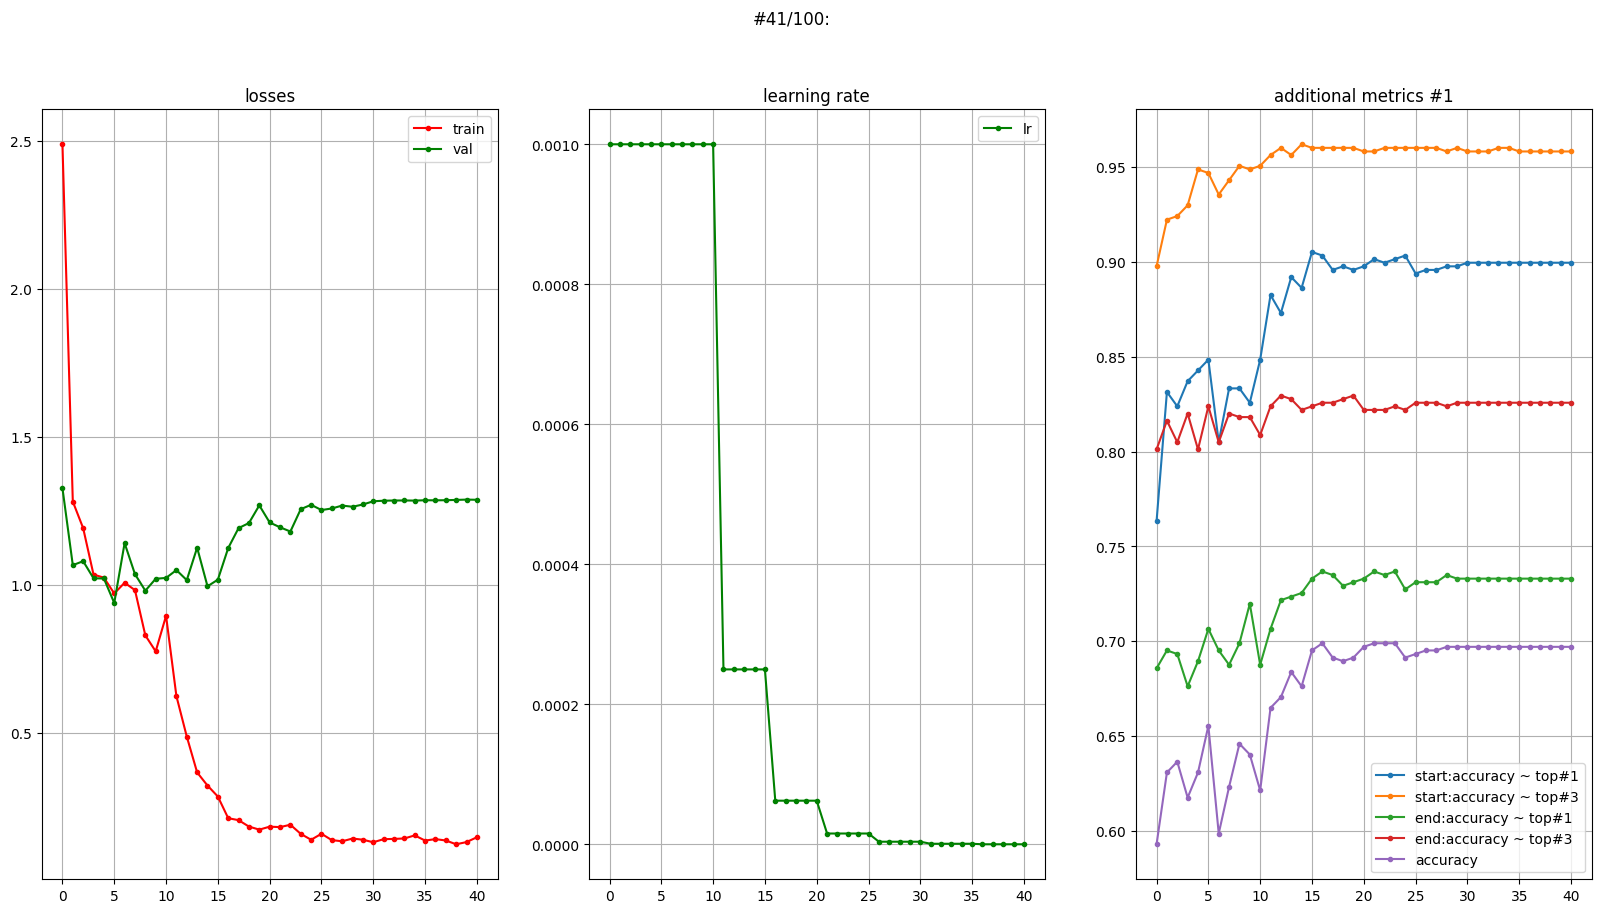

Learning process ended with early stop after epoch 41


In [18]:
params_index = 3
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)

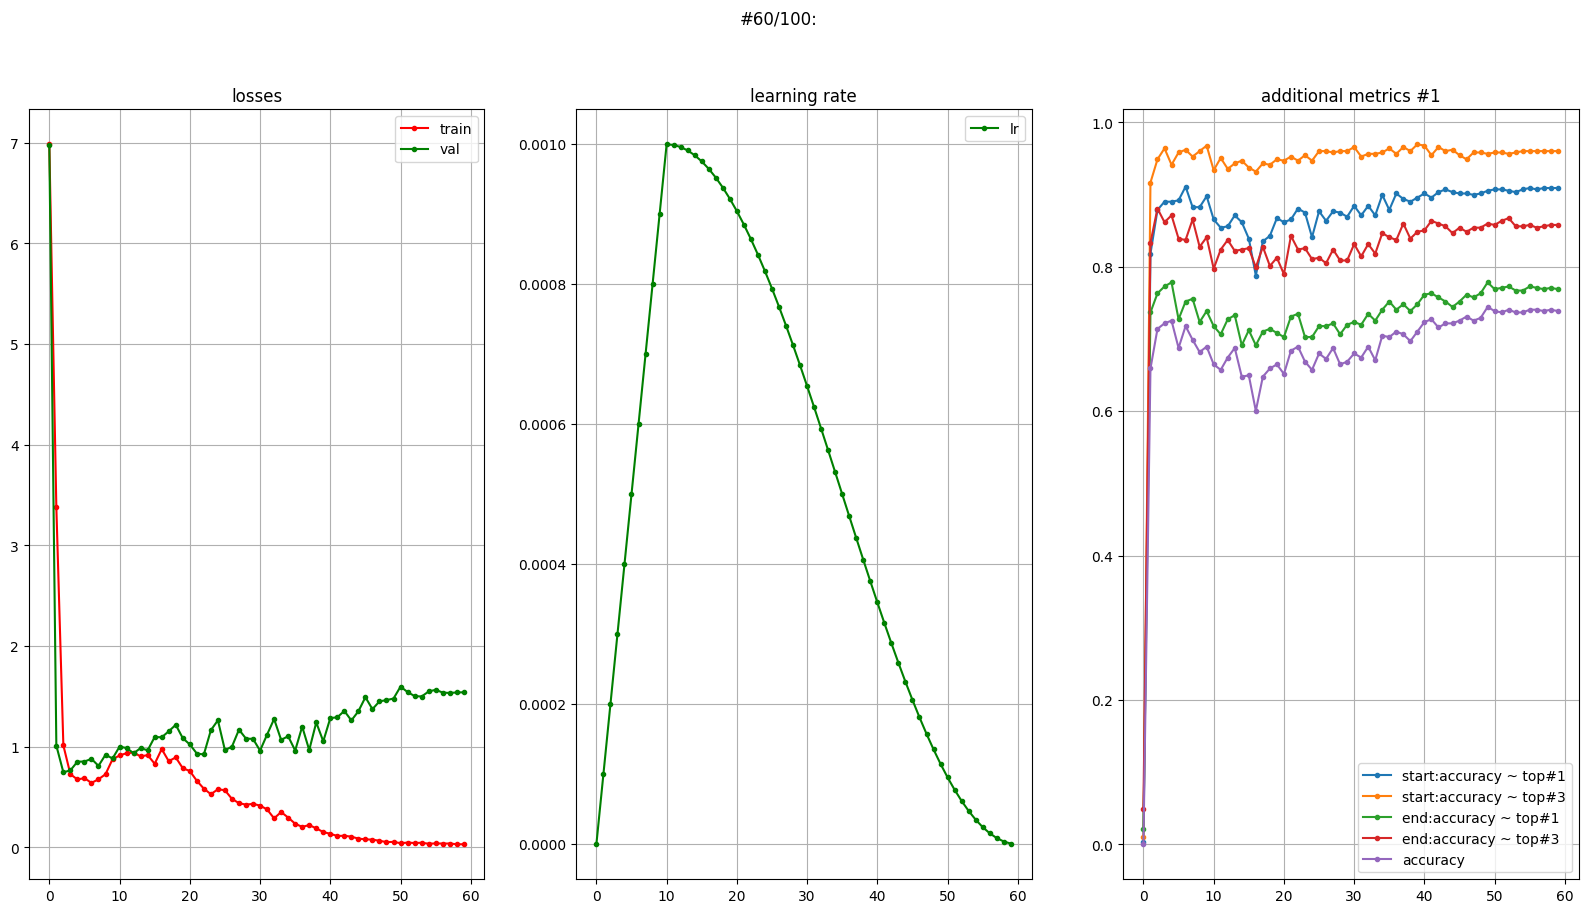

Learning process ended with early stop after epoch 60


In [19]:
params_index = 4
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)

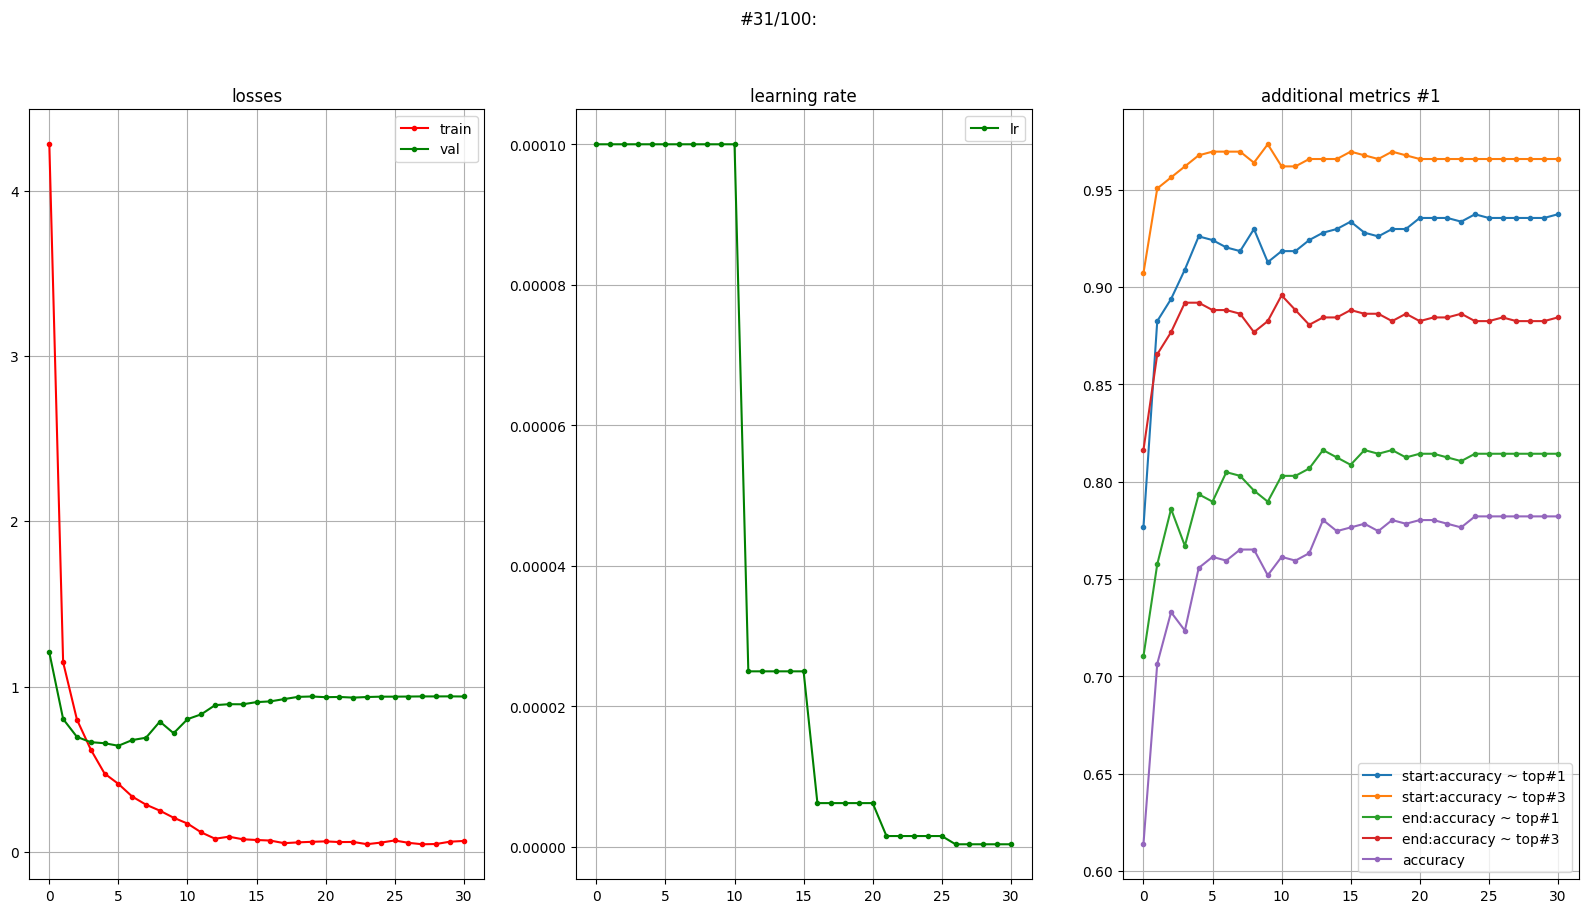

Learning process ended with early stop after epoch 31


In [20]:
params_index = 5
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)

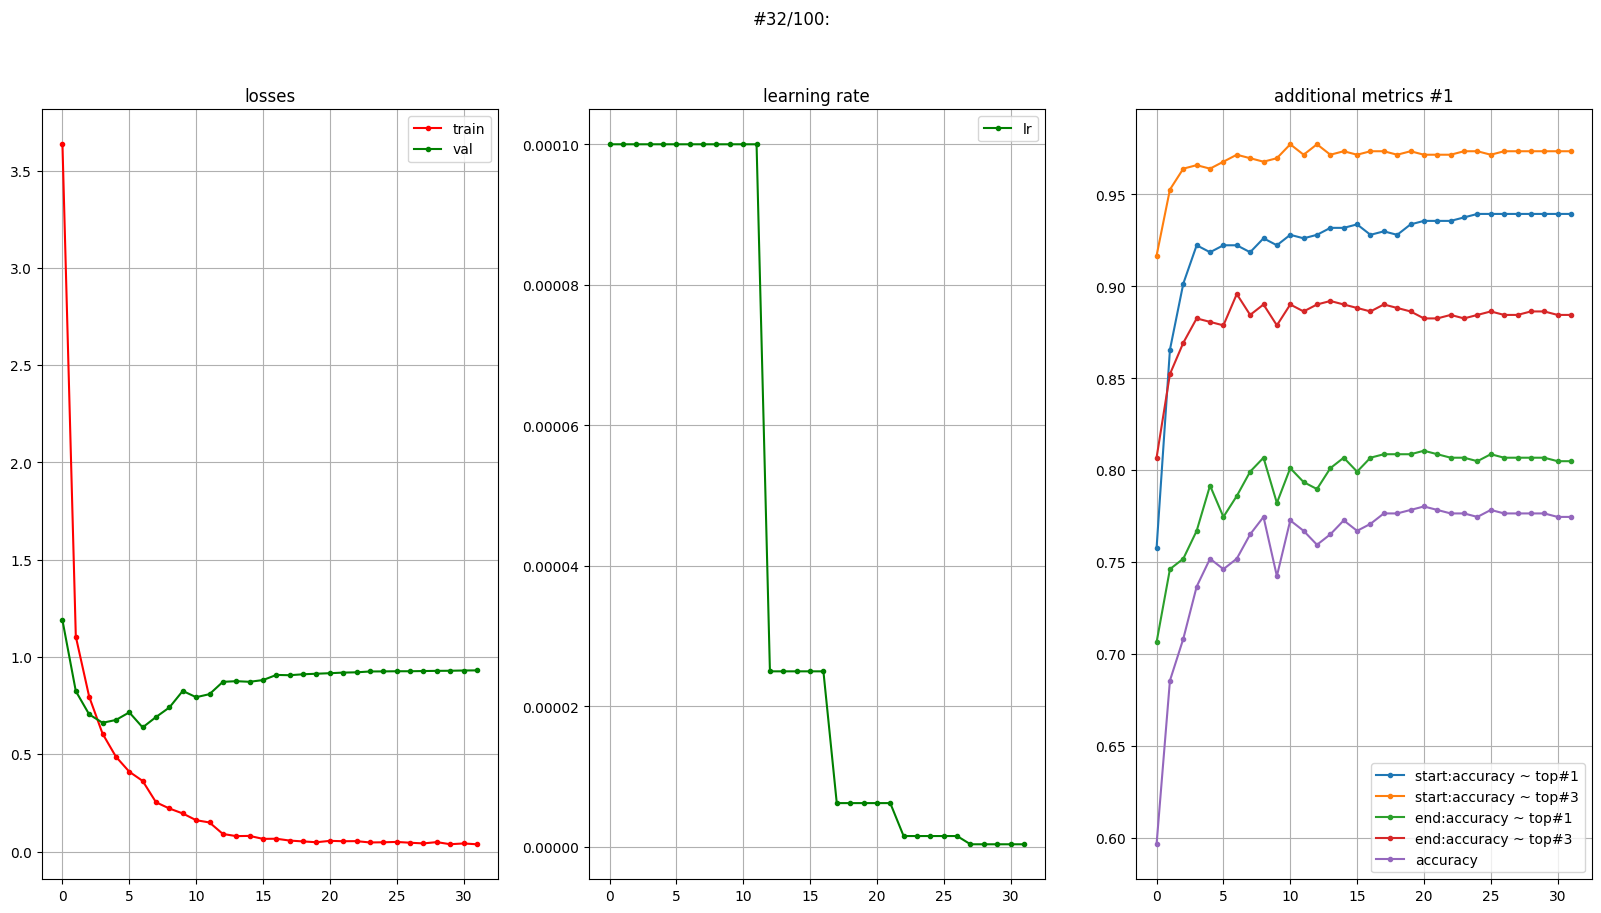

Learning process ended with early stop after epoch 32


In [17]:
params_index = 6
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)

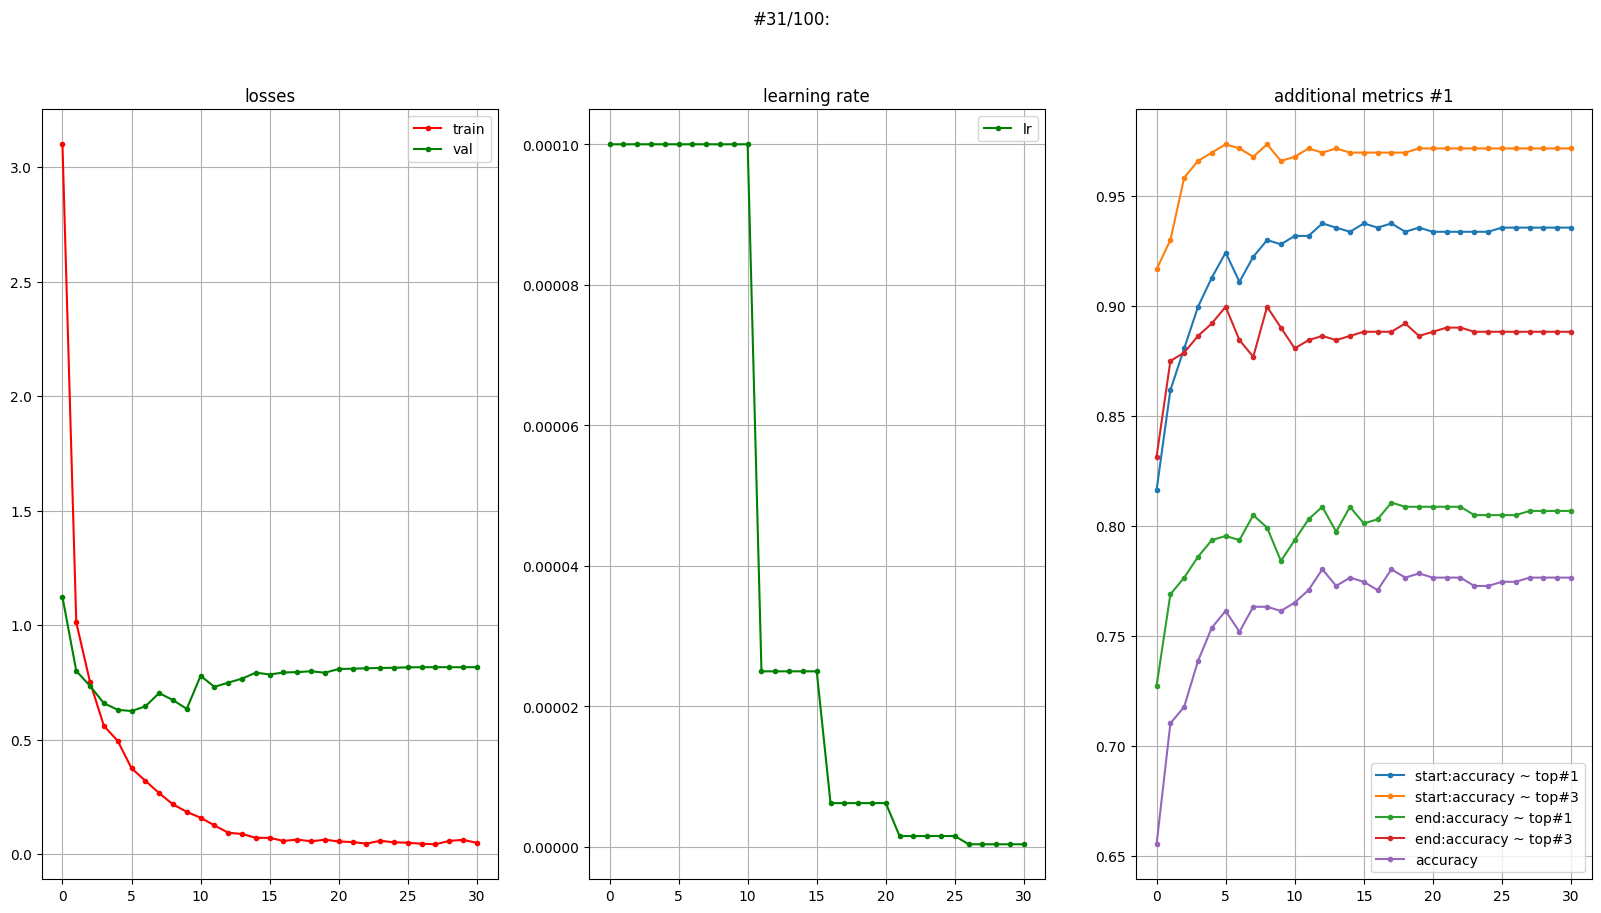

Learning process ended with early stop after epoch 31


In [12]:
params_index = 7
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)

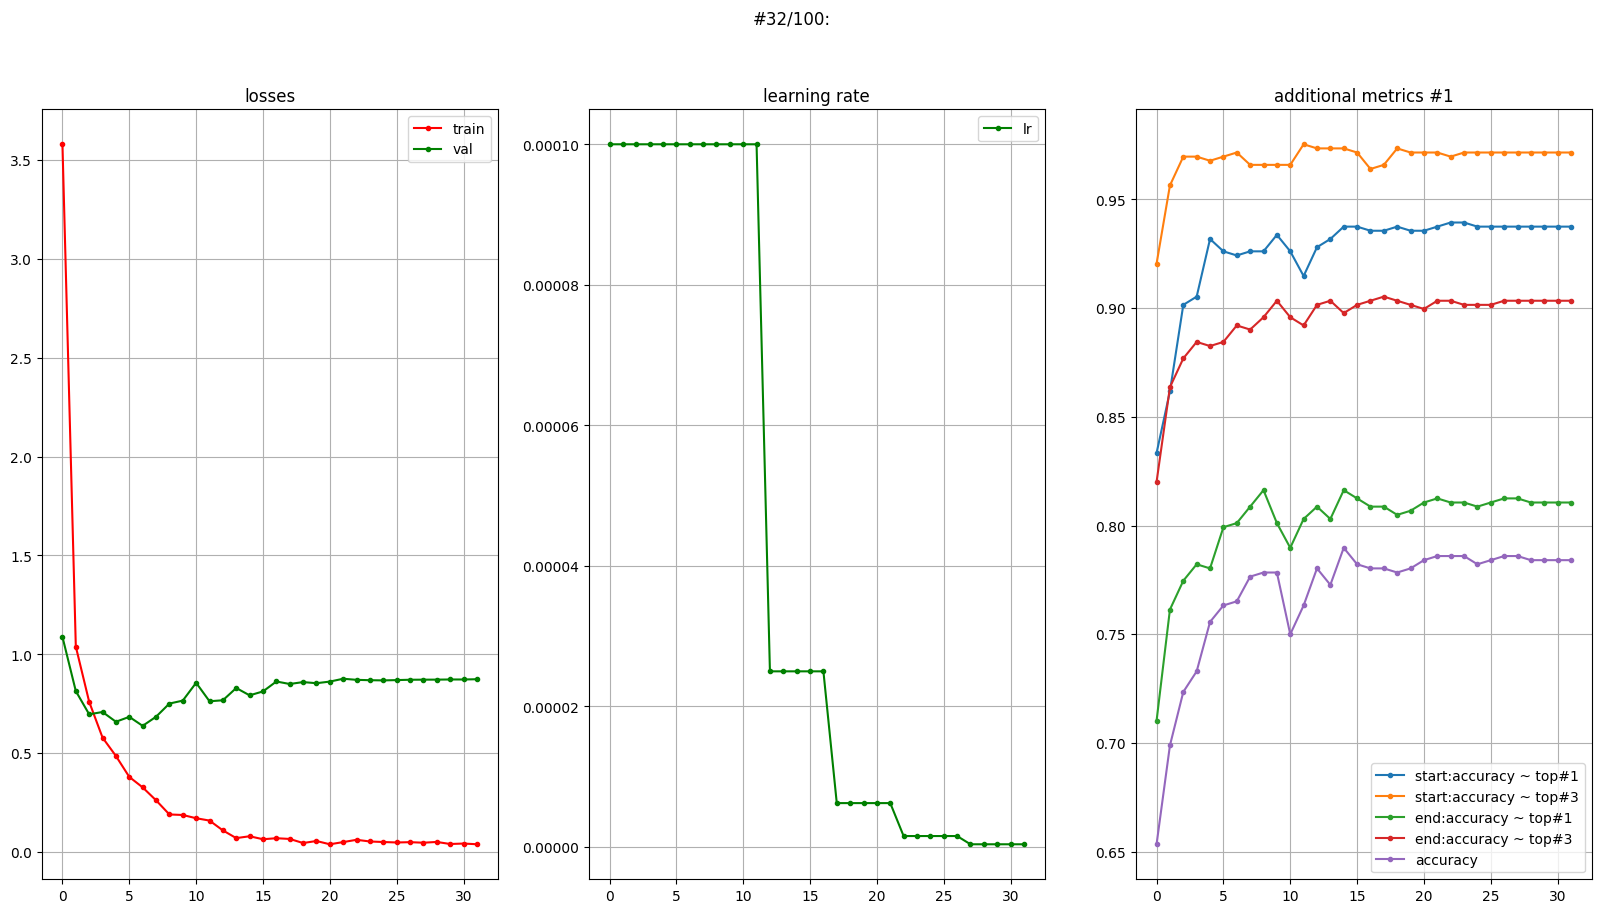

Learning process ended with early stop after epoch 32


In [24]:
params_index = 8
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)

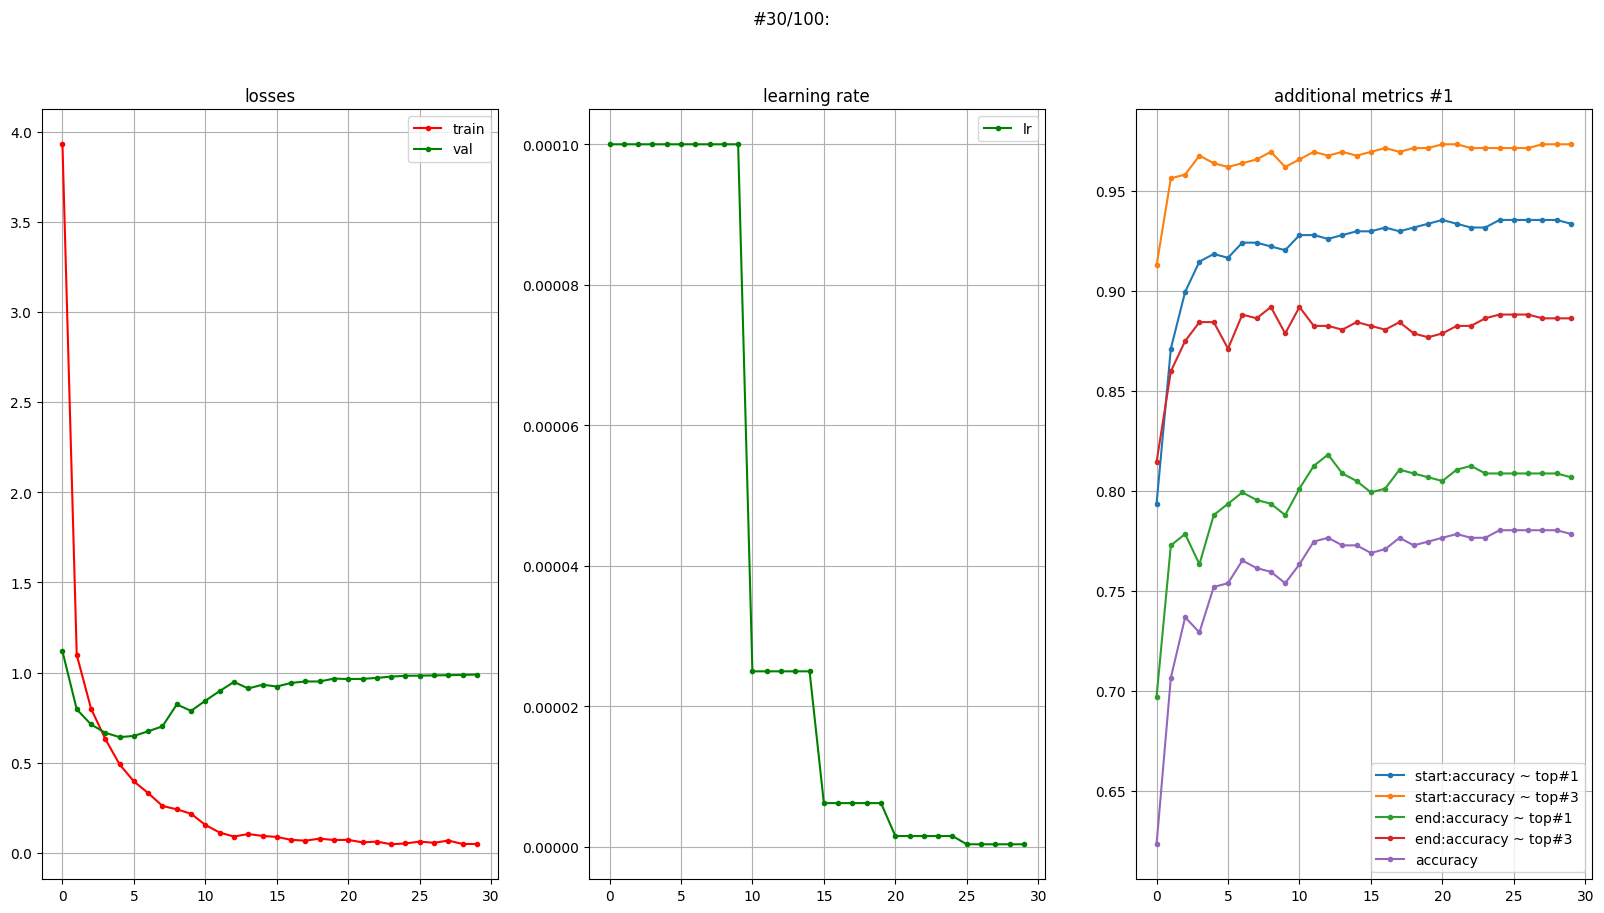

Learning process ended with early stop after epoch 30


In [25]:
params_index = 9
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)

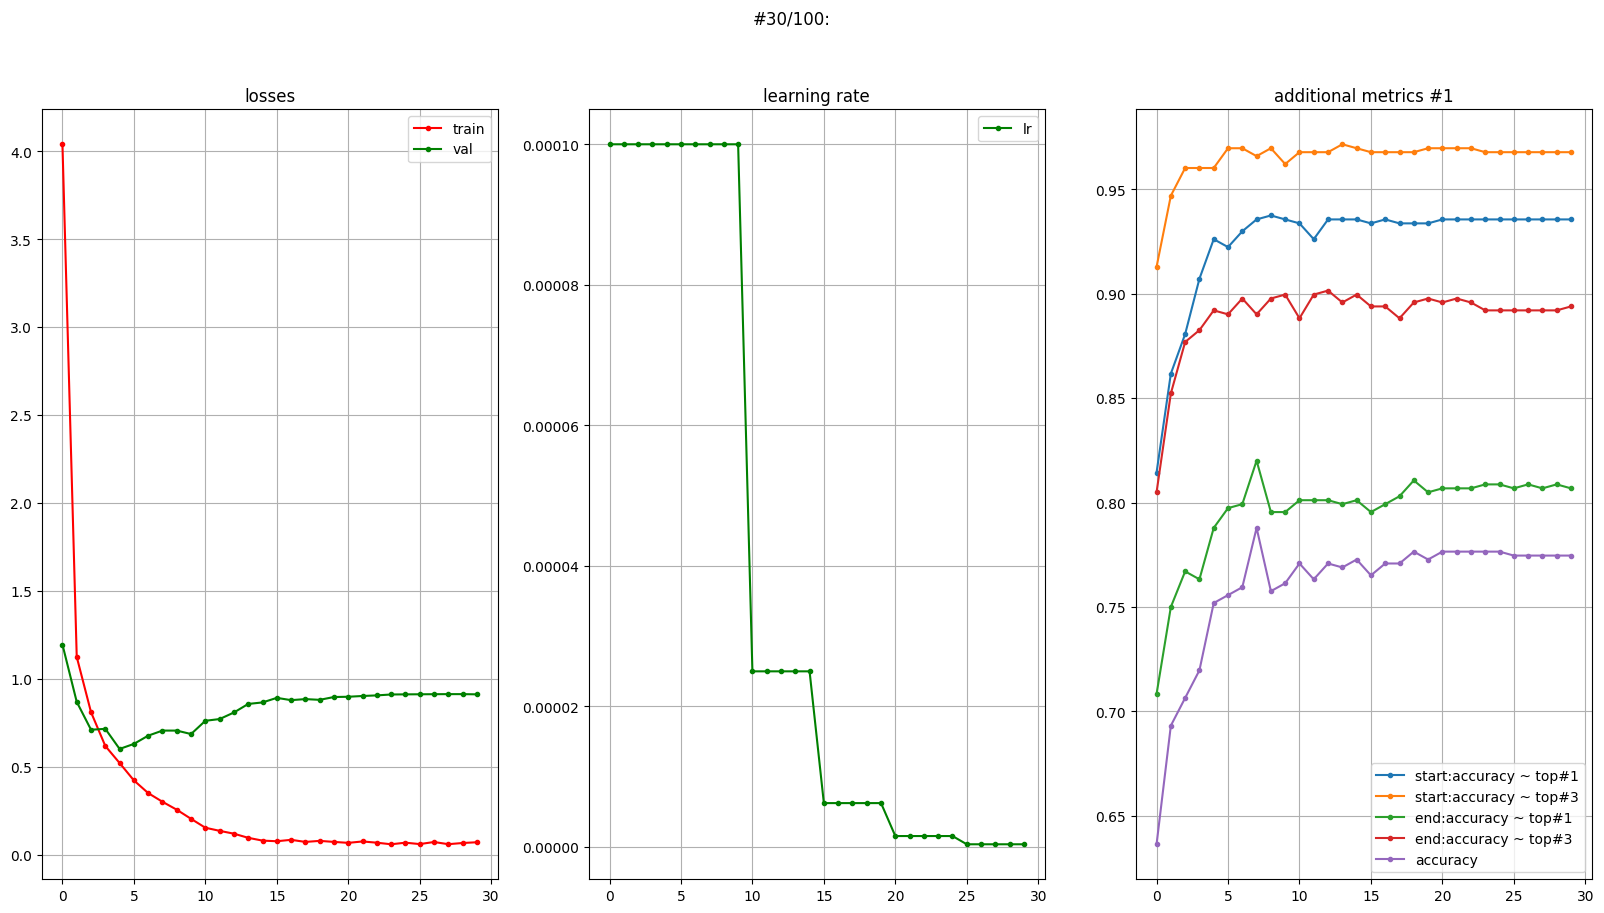

Learning process ended with early stop after epoch 30


In [26]:
params_index = 10
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)

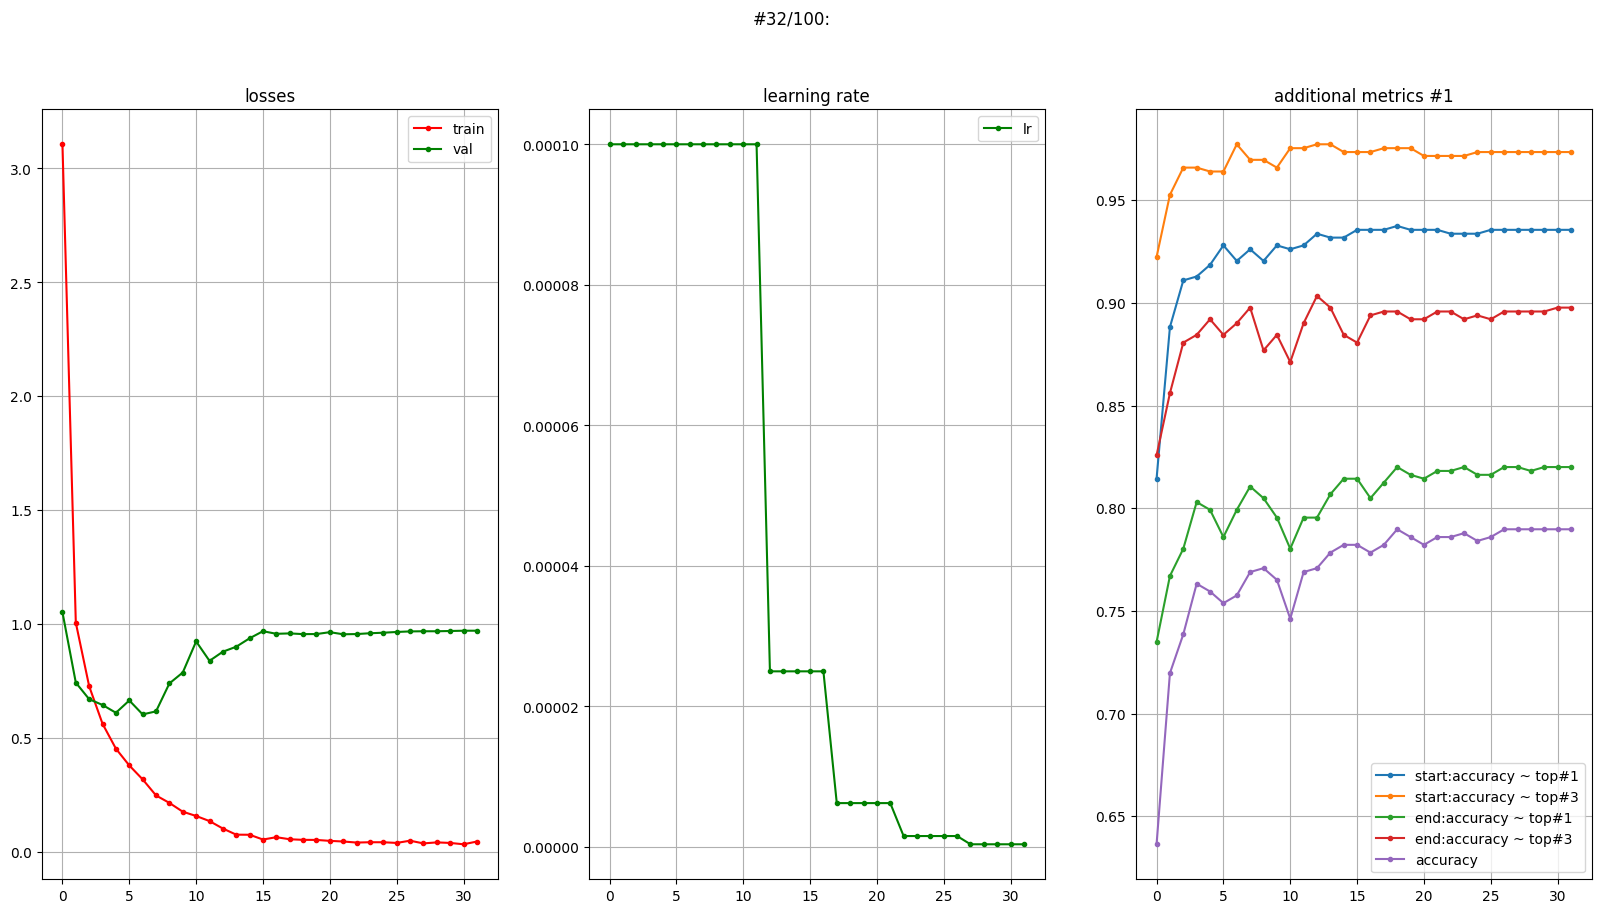

Learning process ended with early stop after epoch 32


In [27]:
params_index = 11
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)

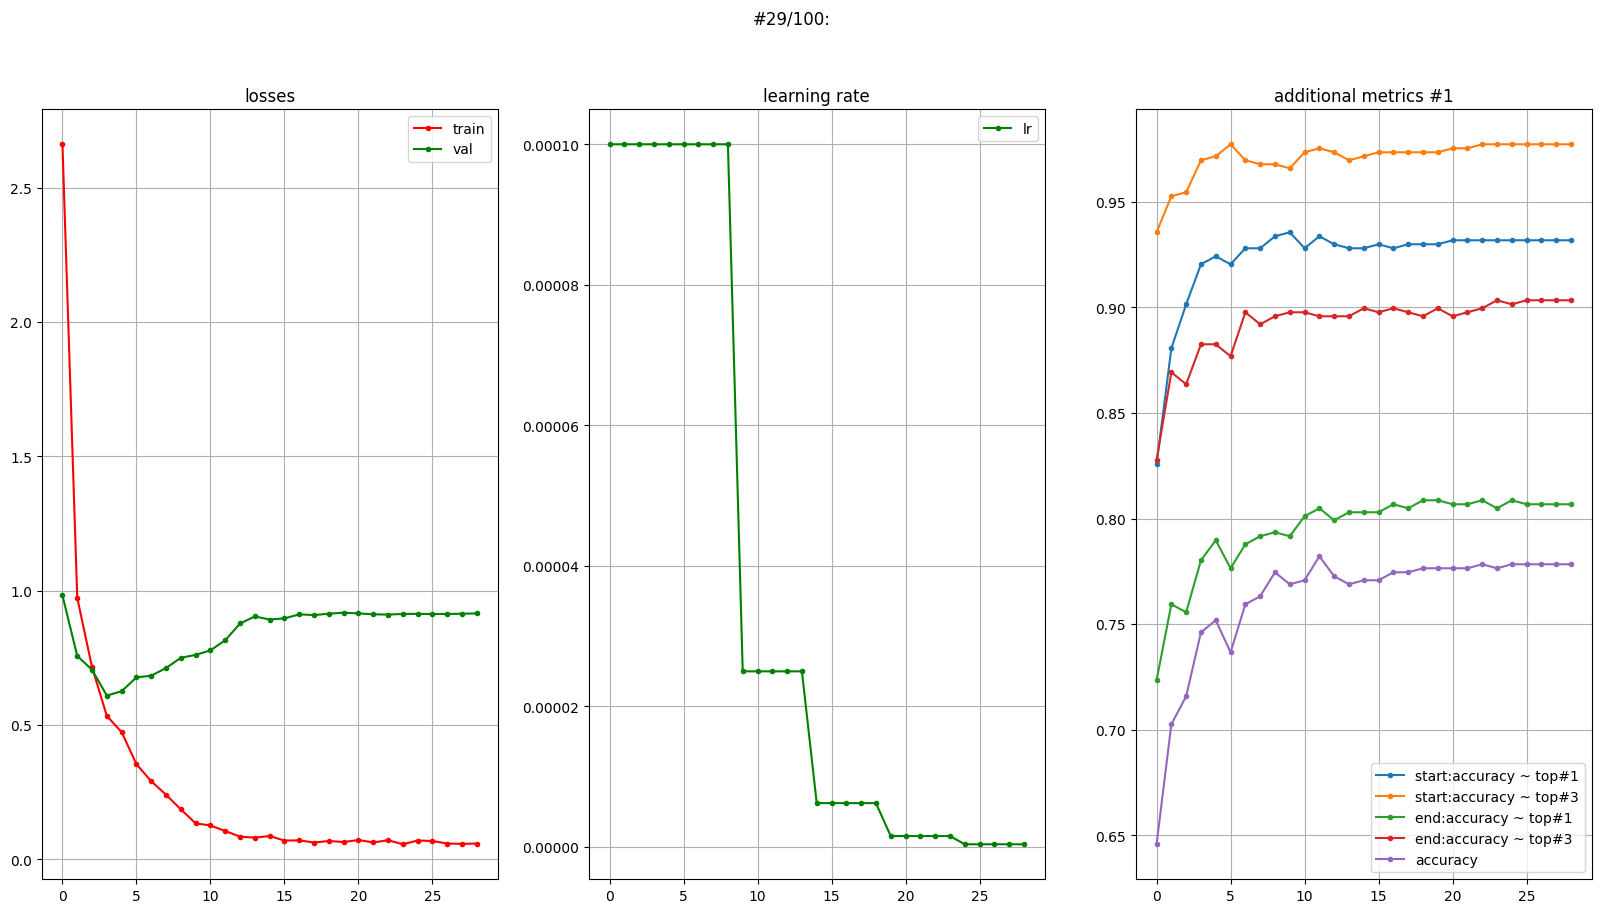

Learning process ended with early stop after epoch 29


In [28]:
params_index = 12
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)

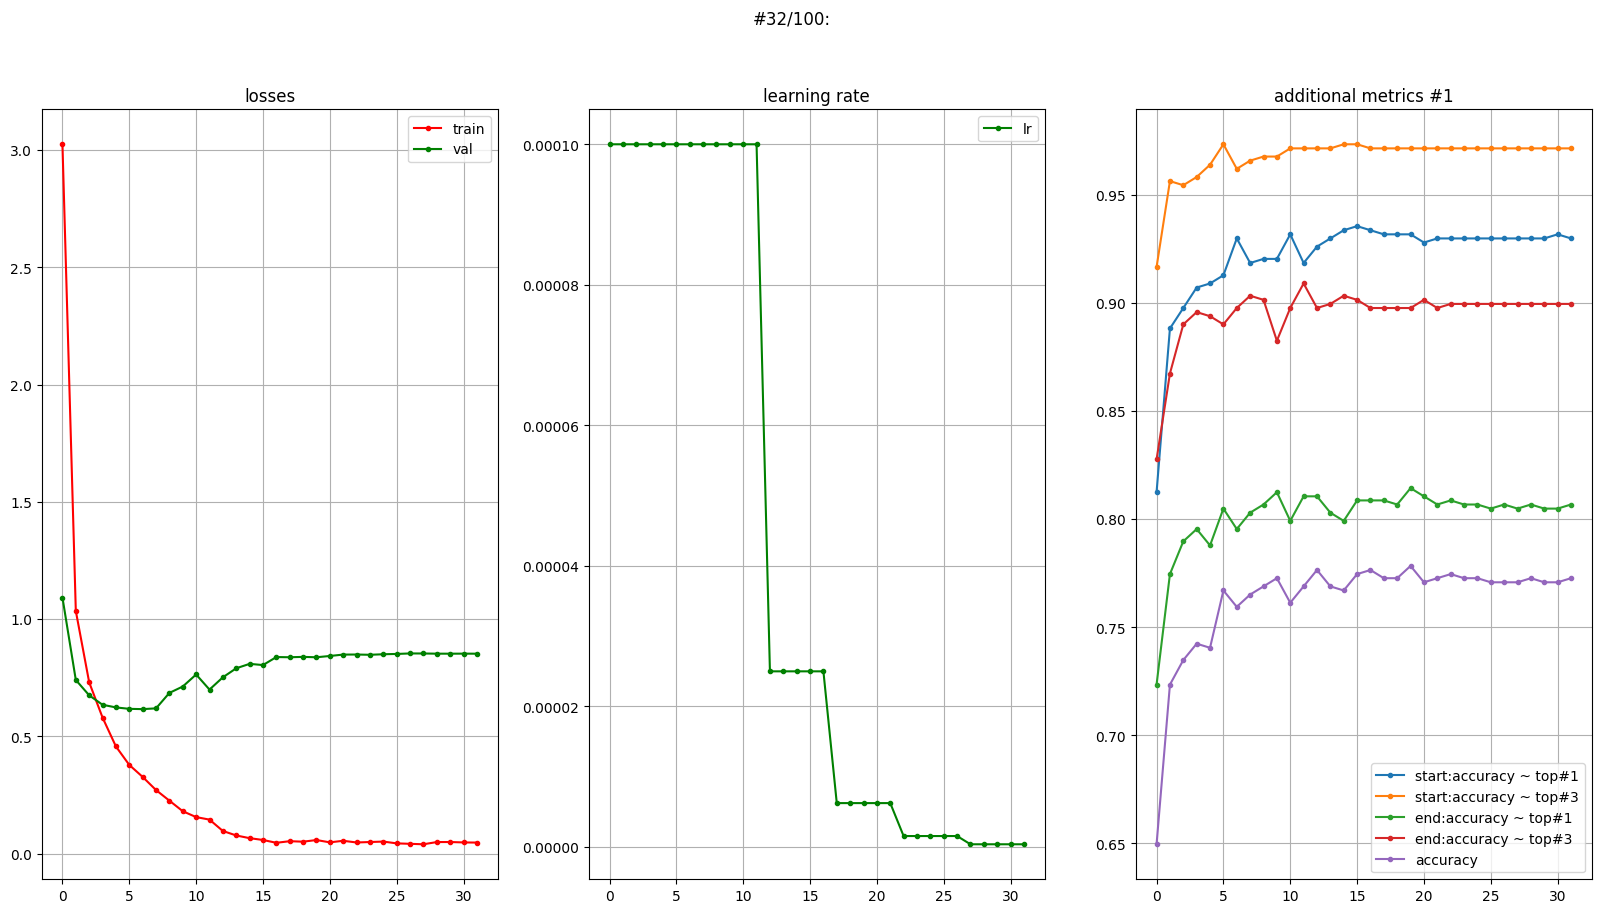

Learning process ended with early stop after epoch 32


In [30]:
params_index = 13
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)

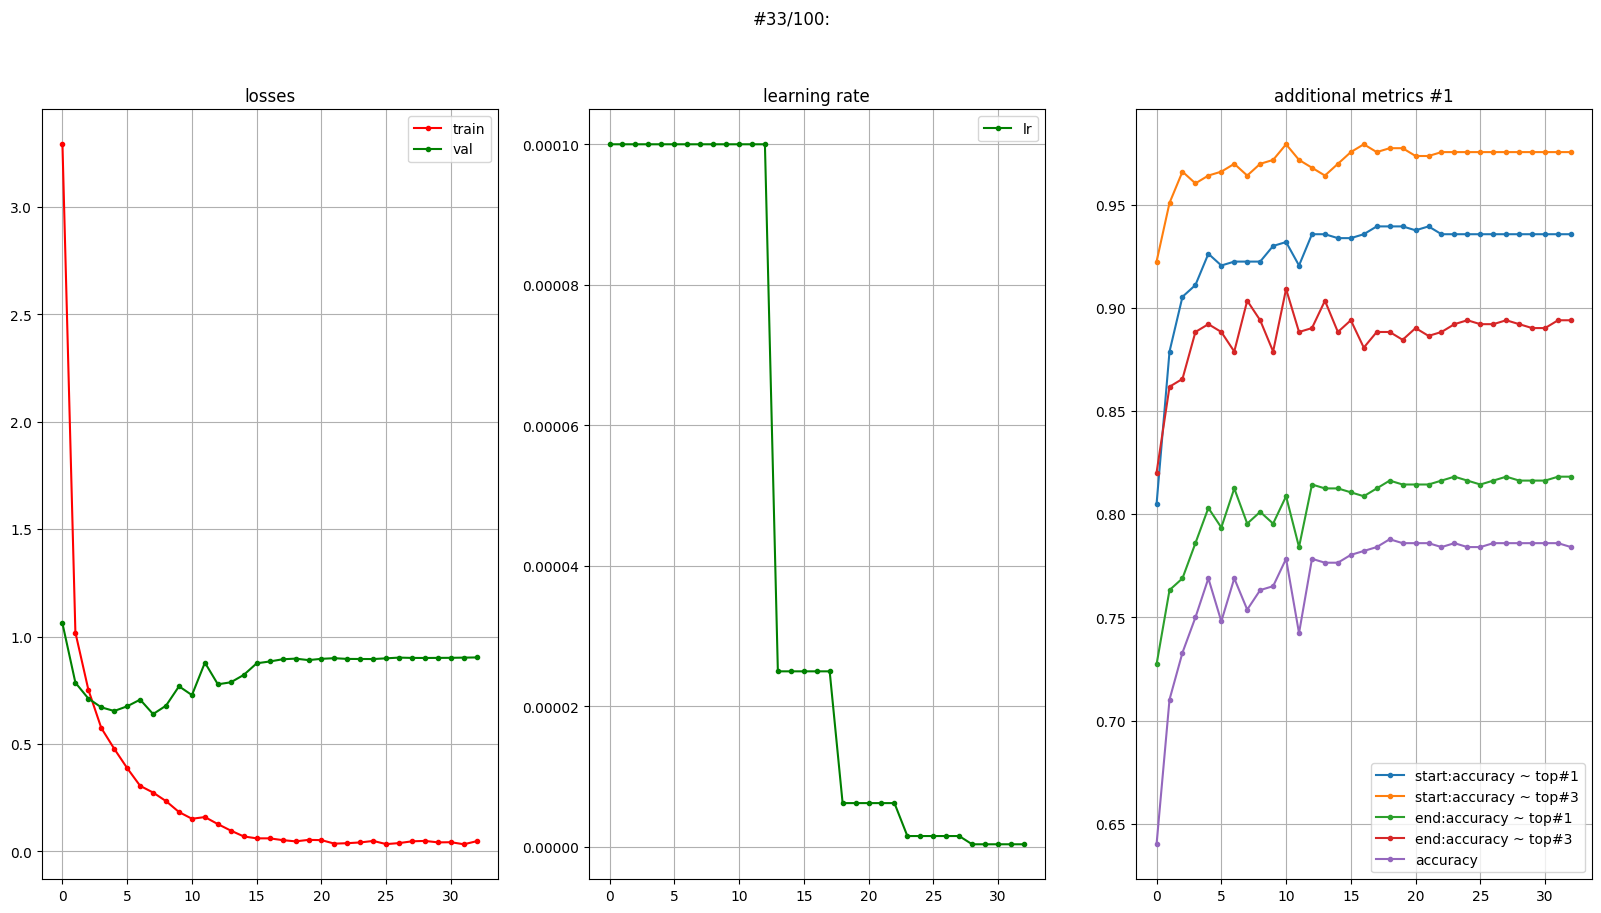

Learning process ended with early stop after epoch 33


In [31]:
params_index = 14
model_name = create_name(zoo_params[params_index])
learn_model_with(zoo_params[params_index], model_name, model_name)